# **Partie 1 : étude de faisabilité des features texte**





Dans le cadre de notre mission en tant que Data Scientist chez "Place de marché", nous avons pour objectif d'automatiser l'attribution des catégories pour les articles proposés sur notre plateforme e-commerce. Actuellement, cette tâche est réalisée manuellement par les vendeurs, ce qui peut engendrer des erreurs et des incohérences. Avec la croissance prévue du volume d'articles, il devient crucial de développer un moteur de classification automatique des articles basé sur leur description textuelle et leur image. Linda, notre Lead Data Scientist, nous a confié la réalisation d'une étude de faisabilité pour ce projet. Cette étude comprendra l'analyse des données textuelles et visuelles, l'extraction de features, et l'évaluation de la possibilité de regrouper les articles par catégorie de manière automatique.

Sommaire :



*   Préparation des données
*   Segmentation des produits via leur description




Numérisation du texte : approches fréquentistes



*   CountVectorizer
*   TF-IDF



Numérisation du texte : approche embedding



*   Word2Vec
*   BERT
*   USE





## Texte : Etape 1

### Import des données

Dans un premier temps, nous importons le jeu de données nécessaire à ce projet, ainsi que l’ensemble des modules Python indispensables à son traitement.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/flipkart_com-ecommerce_sample_1050.csv')
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Le jeu de donnée ne contient pas de valeurs nulles, excepté pour la colonne "brand", que nous n'allons pas utiliser pour la suite de notre projet.

Nous pouvons maintenant commencer le traitement des données textuelles au sein de notre jeu de donnée.

In [ ]:
from collections import Counter

# Créer une liste de tous les mots de la colonne product_name
all_words = ' '.join(data['product_name'].astype(str).tolist()).lower().split()

# Compter les occurrences de chaque mot
word_counts = Counter(all_words)

# Afficher les résultats
print(word_counts.most_common(20))


[('-', 285), ('for', 169), ('watch', 150), ('set', 132), ('analog', 127), ('cm', 109), ('showpiece', 105), ('baby', 94), ('combo', 93), ('ceramic', 78), ('mug', 76), ('&', 71), ('men', 63), ('usb', 60), ('cotton', 55), ('women', 49), ("girl's", 48), ('with', 46), ('single', 45), ('and', 42)]


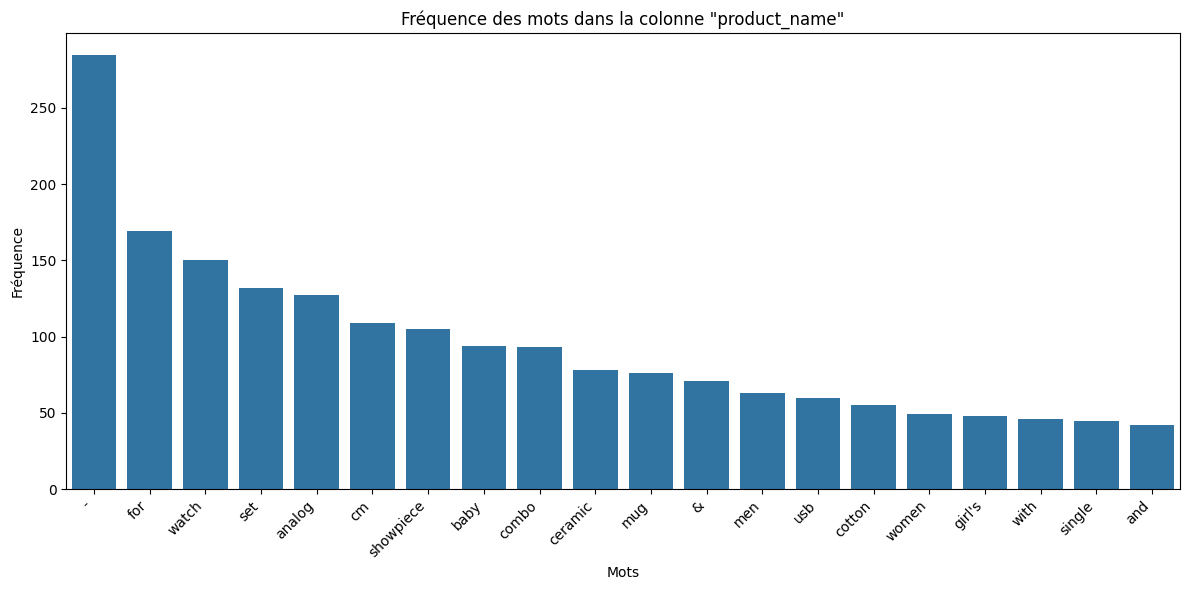

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtiens les mots et leurs fréquences
words, frequencies = zip(*word_counts.most_common(20))  # Utilise les 20 mots les plus fréquents

# Crée l'histogramme
plt.figure(figsize=(12, 6))
sns.barplot(x=words, y=frequencies)  # Convertis words et frequencies en listes
plt.title('Fréquence des mots dans la colonne "product_name"')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')  # Fait pivoter les étiquettes de l'axe des x pour une meilleure lisibilité
plt.tight_layout()
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Crée une liste de tous les mots de la colonne product_name
all_words_2 = ' '.join(data['description'].astype(str).tolist()).lower().split()

# Compte les occurrences de chaque mot
word_counts_2 = Counter(all_words_2)

# Obtiens la liste des stop words en anglais
stop_words = set(stopwords.words('english'))


# Filtre word_counts_2 et le reconvertis en Counter
filtered_words = [word for word in all_words_2 if word not in stop_words]
word_counts_2 = Counter(filtered_words) # Recrée word_counts_2 en tant que Counter

print(word_counts_2.most_common(20)) # Affiche les 20 mots les plus fréquents


[('-', 910), ('free', 605), ('rs.', 584), ('buy', 580), ('genuine', 564), ('cash', 564), ('replacement', 557), ('&', 492), ('30', 486), ('day', 478), ('cm', 477), ('products.', 414), ('features', 383), ('shipping.', 381), ('delivery!', 381), ('flipkart.com.', 379), ('1', 365), ('price:', 342), ('guarantee.', 318), ('watch', 316)]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
words_to_delete = ['-','rs.','genuine','&']


# Filtre word_counts_2 et le reconvertis en Counter
filtered_words_2 = [word for word in filtered_words if word not in words_to_delete]
word_counts_3 = Counter(filtered_words_2) # Recrée word_counts_2 en tant que Counter

print(word_counts_3.most_common(20)) # Affiche les 20 mots les plus fréquents


[('free', 605), ('buy', 580), ('cash', 564), ('replacement', 557), ('30', 486), ('day', 478), ('cm', 477), ('products.', 414), ('features', 383), ('shipping.', 381), ('delivery!', 381), ('flipkart.com.', 379), ('1', 365), ('price:', 342), ('guarantee.', 318), ('watch', 316), ('baby', 312), ('general', 288), ('box', 287), ('type', 286)]


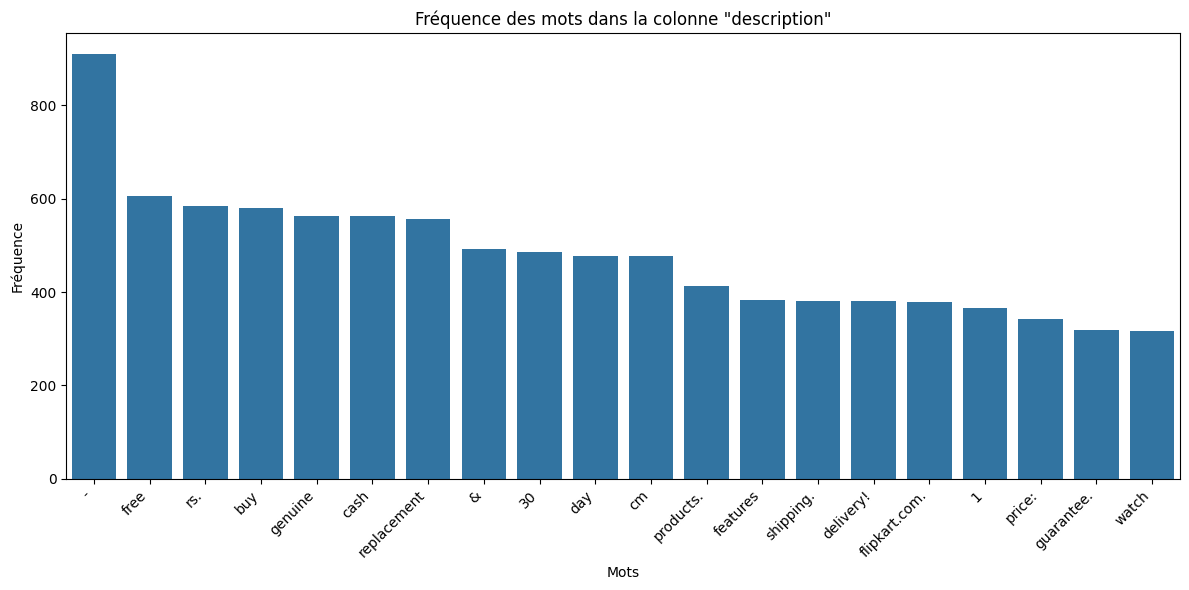

In [ ]:
# Obtenez les mots et leurs fréquences
words_2, frequencies_2 = zip(*word_counts_2.most_common(20))  # Utilisez les 20 mots les plus fréquents

# Créez l'histogramme
plt.figure(figsize=(12, 6))
sns.barplot(x=words_2, y=frequencies_2)
plt.title('Fréquence des mots dans la colonne "description"')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')  # Faites pivoter les étiquettes de l'axe des x pour une meilleure lisibilité
plt.tight_layout()
plt.show()

### Organisation des catégories

Afin de développer un algorithme de classification des produits à partir de leurs descriptions textuelles, nous allons extraire les catégories principales contenues dans la colonne "product_category_tree".

In [ ]:
data['product_category_tree'].value_counts()

,count
product_category_tree,
"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",56
"[""Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs""]",26
"[""Watches >> Wrist Watches >> Maxima Wrist Watches""]",23
"[""Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs""]",22
"[""Home Furnishing >> Bath Linen >> Towels""]",19
...,...
"[""Computers >> Laptop Accessories >> Computer Accessories Combos >> PRINT SHAPES Computer Accessories Combos >> PRINT SHAPES despicable me 2 looking upwards Lap...""]",1
"[""Computers >> Laptop Accessories >> Computer Accessories Combos >> PRINT SHAPES Computer Accessories Combos >> PRINT SHAPES Peacock Feather Laptop Skin with Mo...""]",1
"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Aroma Comfort Polyester Dark Blue Plain Eyelet W...""]",1


In [ ]:
data_test=data.copy()

def split_categories(category_tree):
    """Divise la chaîne de catégories et retourne les parties."""
    try:
        # Extraire la chaîne de la liste et la diviser en utilisant '>>' comme séparateur
        categories = category_tree[0].split(' >> ')
        # Retourner les catégories dans un dictionnaire pour créer les colonnes
        return {'colonne 1': categories[0], 'colonne 2': categories[1], 'colonne 3': categories[2]}
    except (IndexError, TypeError):
        # Gérer les cas où il n'y a pas 3 catégories ou si la valeur est nulle
        return {'colonne 1': None, 'colonne 2': None, 'colonne 3': None}

# Appliquer la fonction à la colonne 'product_category_tree' et créer un nouveau DataFrame
categories_df = data_test['product_category_tree'].apply(split_categories).apply(pd.Series)

# Concaténer le nouveau DataFrame au DataFrame original
data_test = pd.concat([data_test, categories_df], axis=1)

In [ ]:
data_test.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,colonne 1,colonne 2,colonne 3
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",None,None,None
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",None,None,None
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",None,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",None,None,None


In [ ]:
# Supprimer les deux premiers et les deux derniers caractères
data_test['product_category_tree'] = data_test['product_category_tree'].str[2:-2]

# Diviser la colonne 'product_category_tree' en utilisant '>>' comme délimiteur
split_categories = data_test['product_category_tree'].str.split(' >> ', expand=True)

# Renommer les nouvelles colonnes (facultatif)
split_categories.columns = ['categorie_1', 'categorie_2', 'categorie_3', 'categorie_4','categorie_5','categorie_6','cat_7'] # Remplacez par les noms de colonnes souhaités

# Concaténer le DataFrame original avec le nouveau DataFrame contenant les colonnes divisées
data_test = pd.concat([data_test, split_categories], axis=1)


In [ ]:
data_test.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,colonne 1,colonne 2,colonne 3,categorie_1,categorie_2,categorie_3,categorie_4,categorie_5,categorie_6,cat_7
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing >> Curtains & Accessories >> C...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,None,None,None,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,None,None,None,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,None,None,None,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing >> Bed Linen >> Bedsheets >> S...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,None,None,None,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing >> Bed Linen >> Bedsheets >> J...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,None,None,None,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None


In [ ]:
cat_1= data_test['categorie_1'].value_counts()
cat_1

,count
categorie_1,
Home Furnishing,150
Baby Care,150
Watches,150
Home Decor & Festive Needs,150
Kitchen & Dining,150
Beauty and Personal Care,150
Computers,150


<Axes: xlabel='count', ylabel='categorie_1'>

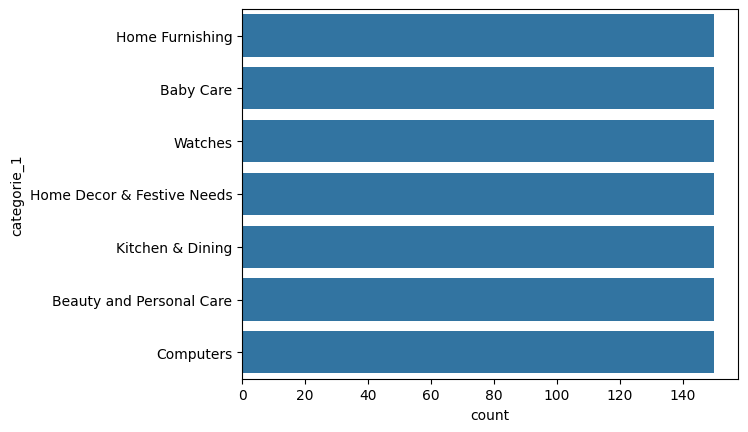

In [ ]:
sns.countplot(data_test["categorie_1"])

<Axes: xlabel='count', ylabel='categorie_2'>

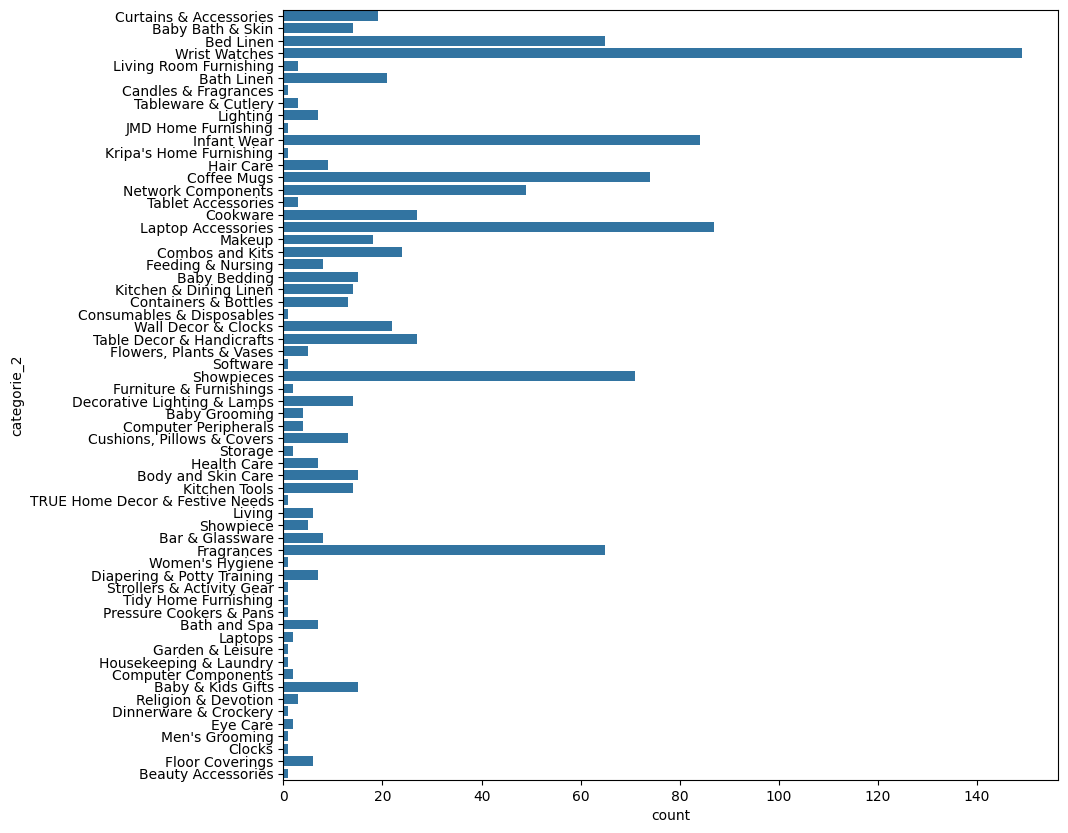

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(data_test["categorie_2"])

## Texte : Etape 2

Maintenant, nous allons passer à la partie plus technique de ce projet, qui consiste à utiliser les textes présents au sein de la colonne "description" du dataframe, afin de créer notre algorithme de classification de biens de consommation.

### Nettoyage du texte

In [ ]:
data_test=data.copy()

 # Supprimer les deux premiers et les deux derniers caractères
data_test['product_category_tree'] = data_test['product_category_tree'].str[2:-2]

# Diviser la colonne 'product_category_tree' en utilisant '>>' comme délimiteur
split_categories = data_test['product_category_tree'].str.split(' >> ', expand=True)

# Renommer les nouvelles colonnes (facultatif)
split_categories.columns = ['categorie_1', 'categorie_2', 'categorie_3', 'categorie_4','categorie_5','categorie_6','cat_7'] # Remplacez par les noms de colonnes souhaités

# Concaténer le DataFrame original avec le nouveau DataFrame contenant les colonnes divisées
data_test = pd.concat([data_test, split_categories], axis=1)

data_test.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,overall_rating,brand,product_specifications,categorie_1,categorie_2,categorie_3,categorie_4,categorie_5,categorie_6,cat_7
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing >> Curtains & Accessories >> C...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing >> Bed Linen >> Bedsheets >> S...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing >> Bed Linen >> Bedsheets >> J...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [ ]:
data_final = data_test.loc[:,['product_name','description','categorie_1']]
data_final.head()

,product_name,description,categorie_1
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


In [ ]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_final['sentence_bow'] = data_final['description'].apply(lambda x : transform_bow_fct(x))
data_final['sentence_bow_lem'] = data_final['description'].apply(lambda x : transform_bow_lem_fct(x))
data_final['sentence_dl'] = data_final['description'].apply(lambda x : transform_dl_fct(x))
data_final.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,product_name,description,categorie_1,sentence_bow,sentence_bow_lem,sentence_dl
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...


In [ ]:
l_cat = list(set(data_final['categorie_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_final.iloc[i]['categorie_1'])) for i in range(len(data_final))]

catégories :  ['Computers', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Baby Care', 'Watches', 'Home Furnishing']


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_final['length_bow'] = data_final['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_final['length_bow'].max())
data_final['length_dl'] = data_final['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_final['length_dl'].max())

max length bow :  379
max length dl :  632


### Fonctions communes

In [ ]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()
    print("ARI : ", ARI)


### CountVectorizer et Tf Idf

In [ ]:
# Création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_final[feat])
ctf_fit = ctf.fit(data_final[feat])

cv_transform = cvect.transform(data_final[feat])
ctf_transform = ctf.transform(data_final[feat])

**Exécution des modèles**

In [ ]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere # if using t-SNE for manifold learning

print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)


CountVectorizer : 
-----------------


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3675 time :  22.0


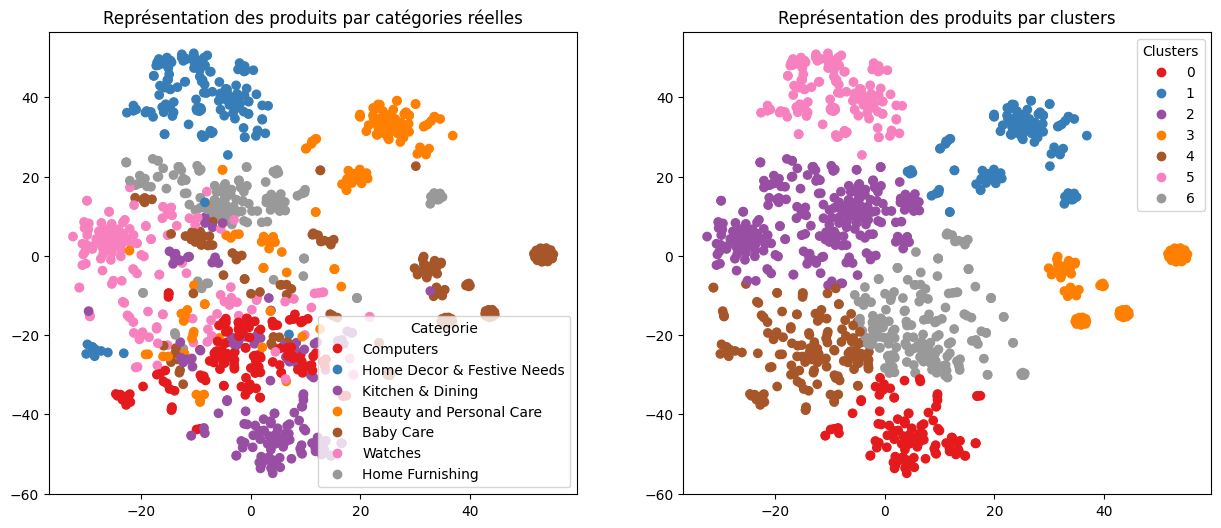

ARI :  0.3675


In [ ]:
 #Graphique TSNE pour CountVectorizer
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [ ]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

Tf-idf : 
--------


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4879 time :  16.0


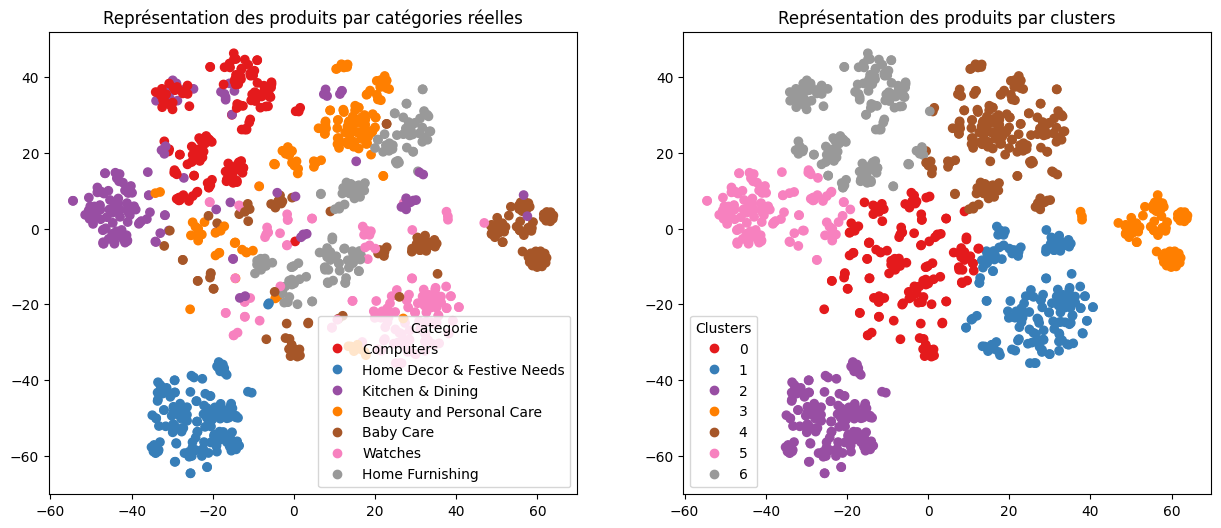

ARI :  0.4879


In [ ]:
 #Graphique TSNE pour Tf-idf
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Word2Vec

**Préparation des données**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import re
from collections import Counter

def clean_and_create_vocab(df, column_name):
    """Nettoie le texte et crée un vocabulaire pour une colonne donnée.

    Args:
        df: DataFrame pandas.
        column_name: Nom de la colonne à traiter.

    Returns:
        Un dictionnaire représentant le vocabulaire.
    """

    all_words = []
    for text in df[column_name].astype(str).tolist():
        # Nettoyage du texte
        cleaned_text = re.sub(r"[^\w\s]", "", text.lower())
        words = cleaned_text.split()
        all_words.extend(words)  # Ajoutez les mots à la liste all_words

    # Créer le vocabulaire
    vocab = sorted(set(all_words))
    word_to_idx = {word: i for i, word in enumerate(vocab)}

    return word_to_idx

# Appliquez la fonction à la colonne "description" de df_final
vocabulary = clean_and_create_vocab(data_final, "description")

print(f"Vocabulaire : {vocabulary}")

Vocabulaire : {'0': 0, '00': 1, '001': 2, '004': 3, '006': 4, '01': 5, '01433cmgy': 6, '01727lpln': 7, '01741lpln': 8, '01784bmly': 9, '02': 10, '0281': 11, '03918cmly': 12, '045lbs': 13, '04615cmgy': 14, '05': 15, '0500': 16, '05712lmly': 17, '05tg16624raw': 18, '05tg87020nblue': 19, '05tg87026antra': 20, '06': 21, '0622': 22, '06362cmgy': 23, '07': 24, '07034lmli': 25, '0750ml': 26, '092': 27, '09321cmgy': 28, '1': 29, '10': 30, '100': 31, '1000': 32, '1001': 33, '101': 34, '101107': 35, '1015': 36, '1016': 37, '101b0101': 38, '102': 39, '1033': 40, '1038': 41, '104': 42, '1042': 43, '1049': 44, '105': 45, '1052': 46, '105key': 47, '1064': 48, '107': 49, '1080': 50, '108121': 51, '1085': 52, '1092': 53, '1099': 54, '109b0109': 55, '10btsc2012gb': 56, '10specifications': 57, '11': 58, '110': 59, '1100': 60, '11000026': 61, '11000026specifications': 62, '1100n1192': 63, '1100n145': 64, '1100n1639': 65, '1100n1685': 66, '1100n1944_b': 67, '1100n1949_b': 68, '1100n2017': 69, '1100n31': 7

**Création des paires Skip-Gram**

In [ ]:
def generate_word_pairs(df, column_name, window_size=2):
    """Génère des paires de mots (cible, contexte) pour une colonne donnée.

    Args:
        df: DataFrame pandas.
        column_name: Nom de la colonne à traiter.
        window_size: Taille de la fenêtre de contexte.

    Returns:
        Une liste de paires de mots (cible, contexte).
    """

    all_pairs = []
    for text in df[column_name].astype(str).tolist():
        # Nettoyage du texte
        cleaned_text = re.sub(r"[^\w\s]", "", text.lower())
        words = cleaned_text.split()

        # Créer le vocabulaire pour ce texte
        vocab = sorted(set(words))
        word_to_idx = {word: i for i, word in enumerate(vocab)}

        # Générer les paires pour ce texte
        for idx, word in enumerate(words):
            for neighbor in range(-window_size, window_size + 1):
                if neighbor == 0 or idx + neighbor < 0 or idx + neighbor >= len(words):
                    continue
                all_pairs.append((word_to_idx[word], word_to_idx[words[idx + neighbor]]))

    return all_pairs

# Appliquez la fonction à la colonne "description" de df_final
word_pairs = generate_word_pairs(data_final, "description")

print("Exemples de paires (mot_cible, mot_contexte) :", word_pairs[:5])

Exemples de paires (mot_cible, mot_contexte) : [(65, 45), (65, 82), (45, 65), (45, 82), (45, 38)]


**Création du modèle Word2Vec (Skip-Gram)**

In [ ]:
import torch
import torch.nn as nn
import re
from collections import Counter

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding_in = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_out = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target, context):
        target_embedding = self.embedding_in(target)
        context_embedding = self.embedding_out(context)
        score = torch.mul(target_embedding, context_embedding).sum(dim=1)
        return score

def clean_and_create_vocab(df, column_name):
    """Nettoie le texte et crée un vocabulaire pour une colonne donnée."""
    all_words = []
    for text in df[column_name].astype(str).tolist():
        cleaned_text = re.sub(r"[^\w\s]", "", text.lower())
        words = cleaned_text.split()
        all_words.extend(words)
    vocab = sorted(set(all_words))
    word_to_idx = {word: i for i, word in enumerate(vocab)}
    return word_to_idx, len(vocab)  # Retourne vocab_size également

# Préparez les données
word_to_idx, vocab_size = clean_and_create_vocab(data_final, "description")
word_pairs = generate_word_pairs(data_final, "description")  # Utilisez la fonction generate_word_pairs de la réponse précédente

# Créez le modèle
embedding_dim = 50
model = Word2Vec(vocab_size, embedding_dim)

# Exemple d'utilisation
targets = torch.tensor([pair[0] for pair in word_pairs[:5]], dtype=torch.long)
contexts = torch.tensor([pair[1] for pair in word_pairs[:5]], dtype=torch.long)
scores = model(targets, contexts)

print("Scores :", scores)

Scores : tensor([9.7432, 0.9345, 3.7973, 8.3252, 1.6172], grad_fn=<SumBackward1>)


In [ ]:
#Fonction de perte et optimiseur

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

**Préparation des données pour l'entraînement**

In [ ]:
# Créer les tenseurs pour les mots cibles et les mots contextuels
target_words = torch.tensor([pair[0] for pair in word_pairs], dtype=torch.long)
context_words = torch.tensor([pair[1] for pair in word_pairs], dtype=torch.long)

# Créer les labels (1 pour vrai contexte, 0 pour du négatif sampling)
labels = torch.ones(len(word_pairs), dtype=torch.float)


**Entrainement du modèle**

In [ ]:
# Boucle d'entraînement
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad() # Réinitialiser les gradients

    # Prédiction
    outputs = model(target_words, context_words)

    # Calcul de la perte
    loss = criterion(outputs, labels)

    # Backpropagation
    loss.backward()
    optimizer.step() # Mettre à jour les poids du modèle

    # Affichage de la perte
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 2.8948
Epoch 10, Loss: 2.1679
Epoch 20, Loss: 1.5433
Epoch 30, Loss: 0.9895
Epoch 40, Loss: 0.5488
Epoch 50, Loss: 0.2606
Epoch 60, Loss: 0.1095
Epoch 70, Loss: 0.0455
Epoch 80, Loss: 0.0208
Epoch 90, Loss: 0.0108


**Extraction des vecteurs de mots**

In [ ]:
# Récupérer les embeddings
embeddings = model.embedding_in.weight.data.numpy()

# Afficher l'embedding pour un mot spécifique
word = "carries" # Remplacez par le mot que vous voulez
if word in word_to_idx:
    word_embedding = embeddings[word_to_idx[word]]
    print(f"Vecteur pour le mot '{word}' : {word_embedding}")
else:
    print(f"Le mot '{word}' n'est pas dans le vocabulaire.")


Vecteur pour le mot 'carries' : [ 1.5807006   1.8095835  -0.26838383  2.2959123   1.7517993  -0.6170155
 -1.0435805  -0.23799515  2.060145    0.29342148  0.10027351 -0.30015236
  0.56843644  0.3105904  -0.05822572  0.9528908  -0.2040495   0.27312562
 -0.7139035   1.3178958   0.31826505 -1.0602638   0.05514647  0.04938878
  1.6397587  -0.5647005   0.16029242  1.6479462  -0.1746775   0.8793233
 -1.9353733   0.59063077 -0.2335994  -0.82545096 -1.1299306   0.554248
 -1.9559647   1.3333002   0.296377   -0.44391075  0.73707587 -0.31384543
 -0.23029736 -1.3730645  -1.5754281  -0.6305607  -0.9011782   1.3665037
 -0.02867033  0.23873195]


**Trouver les mots similaires (Cosine Similarity)**

In [ ]:
#Trouver les mots similaires
from sklearn.metrics.pairwise import cosine_similarity

# Normaliser les embeddings
norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Créer un dictionnaire inverse pour mapper les index aux mots
idx_to_word = {i: word for word, i in word_to_idx.items()}

def find_similar(word, top_n=5):
    """Trouve les mots les plus similaires à un mot donné."""
    if word in word_to_idx:
        idx = word_to_idx[word]
        similarities = cosine_similarity([norm_embeddings[idx]], norm_embeddings)[0]
        most_similar = np.argsort(-similarities)[1:top_n + 1]  # Exclure le mot lui-même
        return [(idx_to_word[i], similarities[i]) for i in most_similar]
    else:
        print(f"Le mot '{word}' n'est pas dans le vocabulaire.")
        return []

# Trouver les mots similaires
similar_words = find_similar('carries', top_n=10)  # Trouver les 10 mots les plus similaires
print("Mots similaires à 'carries' :", similar_words)


Mots similaires à 'carries' : [('smooth', np.float32(0.56929415)), ('kosher', np.float32(0.47673967)), ('hardcore', np.float32(0.47648168)), ('rs449', np.float32(0.47128043)), ('constructed', np.float32(0.45832443)), ('folks', np.float32(0.43486202)), ('outings', np.float32(0.4325597)), ('concrete', np.float32(0.42803717)), ('asias', np.float32(0.4276933)), ('05', np.float32(0.4268786))]


**Application du modèle**

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


# 1. Appliquer la réduction de dimensionnalité avec t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# 2. Effectuer le clustering avec KMeans (ou un autre algorithme)
n_clusters = len(l_cat)  # Utilisez le nombre de catégories réelles pour les clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)  # Clustering sur les embeddings originaux

# 3. Calculer l'ARI
ARI = adjusted_rand_score(y_cat_num, labels)

# 4. Appeler votre fonction de visualisation
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### BERT

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: '__init_subclass__' (from 'transformers.agents.tools') is deprecated and will be removed from version '4.51.0'. Switch to smolagents instead, with the same functionalities and similar API (https://huggingface.co/docs/smolagents/index)
  warnings.warn(warning_message, FutureWarning)
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

**BERT HuggingFace**

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_final['sentence_dl'].to_list()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1/1 [==============================] - 2s 2s/step
temps traitement :  337.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.323 time :  16.0


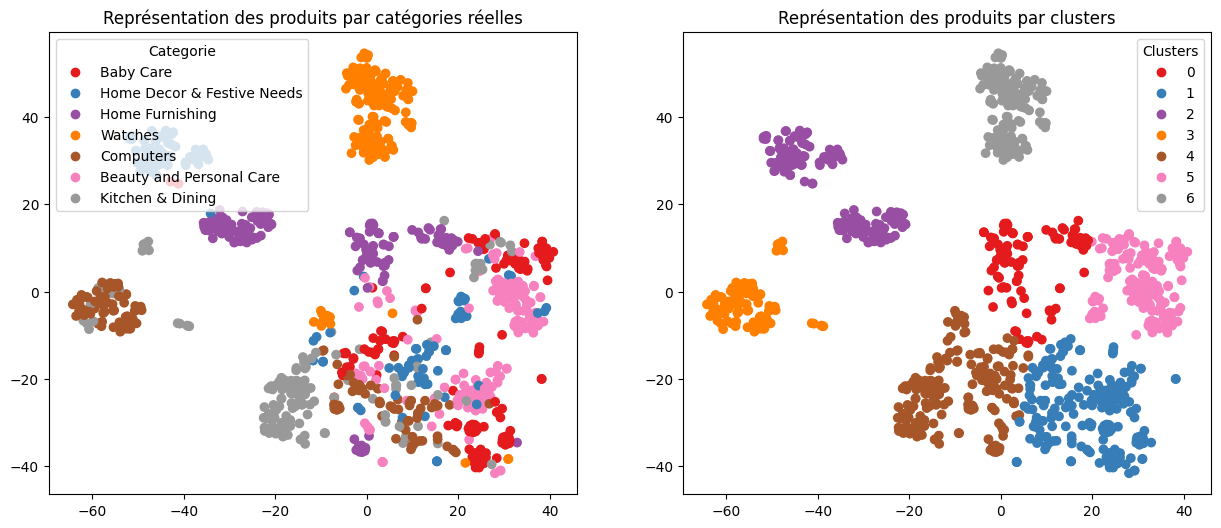

ARI :  0.323


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

**BERT hub Tensorflow**

In [ ]:
import tensorflow_hub as hub
import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
sentences = data_final['sentence_dl'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  292.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3154 time :  16.0


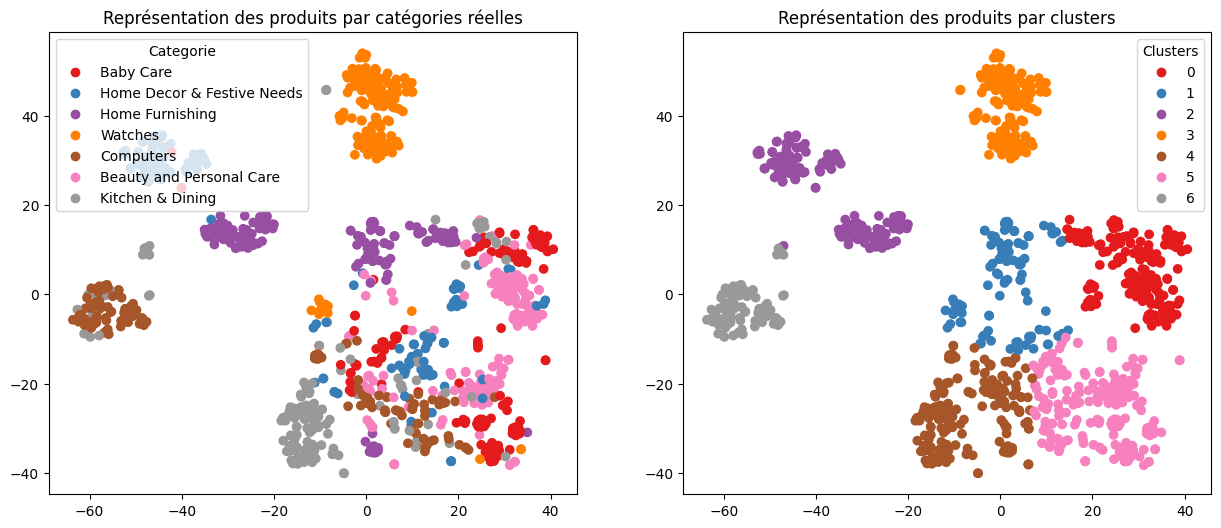

ARI :  0.3154


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = data_final['sentence_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4368 time :  16.0


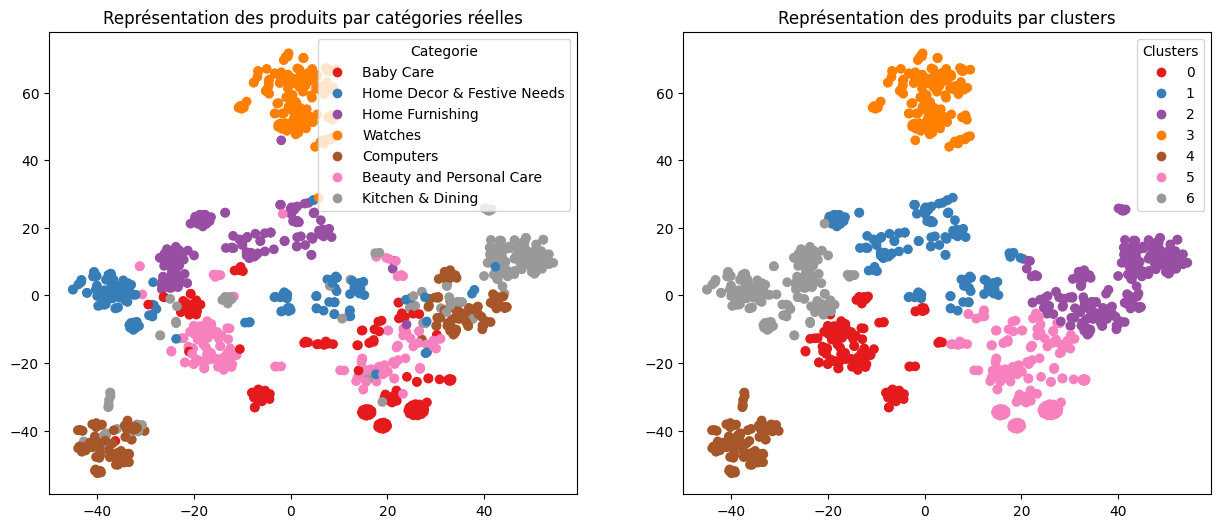

ARI :  0.4368


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Export du dataset pour l'étude de la faisabilité pour les images

In [ ]:
data_test.to_csv('data_test.csv', index=False)